In [3]:
from Counterfactual_SMOTE import CounterfactualSMOTE
import numpy as np
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

Application of Counterfactual SMOTE on a classification task.

In [4]:
def preprocess_liver(random_seed=42, percentage=0.1):

    ilpd_indian_liver_patient_dataset = fetch_ucirepo(id=225)
    X = ilpd_indian_liver_patient_dataset.data.features
    y = ilpd_indian_liver_patient_dataset.data.targets
    y = y[y.index.isin(X.dropna().index)]
    X = X.dropna()
    X.drop("Gender", inplace=True, axis=1)
    y = y.Selector.apply(lambda x: 1 if x == 1 else 0)
    np.random.seed(random_seed)

    if percentage != 1:
        fraction = int(percentage*y[y == 1].shape[0])
        y = pd.concat([y[y == 0], y[y == 1].sample(
            fraction, random_state=random_seed)])
        X = X[X.index.isin(y.index)]
        X = X.sort_index()
        y = y.sort_index()

        y.reset_index(drop=True, inplace=True)
        X.reset_index(drop=True, inplace=True)

    return pd.DataFrame(X), pd.Series(y)

In [5]:
X, y = preprocess_liver(random_seed=22, percentage= 0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\GonçaloAlmeida\AppData\Local\Temp\ipykernel_22300\3532394580.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop("Gender", inplace=True, axis=1)


In [9]:
clf = RandomForestClassifier(random_state=22)
clf.fit(X_train_scaled, y_train)
print(f'F1 Score achieved with no oversampling: {f1_score(y_test, clf.predict(X_test_scaled))}')

smote = SMOTE(random_state=22)
X_synthetic, y_synthetic = smote.fit_resample(X_train_scaled, y_train)
clf.fit(X_synthetic, y_synthetic)
f1_score(y_test, clf.predict(X_test_scaled))
print(f'F1 Score achieved with regular SMOTE: {f1_score(y_test, clf.predict(X_test_scaled))}')

cf_smote = CounterfactualSMOTE(random_state=22)
X_synthetic, y_synthetic = cf_smote.fit_resample(X_train_scaled, y_train)
clf.fit(X_synthetic, y_synthetic)
f1_score(y_test, clf.predict(X_test_scaled))
print(f'F1 Score achieved with Counterfactual SMOTE: {f1_score(y_test, clf.predict(X_test_scaled))}')

F1 Score achieved with no oversampling: 0.4
F1 Score achieved with regular SMOTE: 0.4210526315789474
F1 Score achieved with Counterfactual SMOTE: 0.5714285714285713


Visual Comparison between Counterfactual SMOTE and SMOTE.

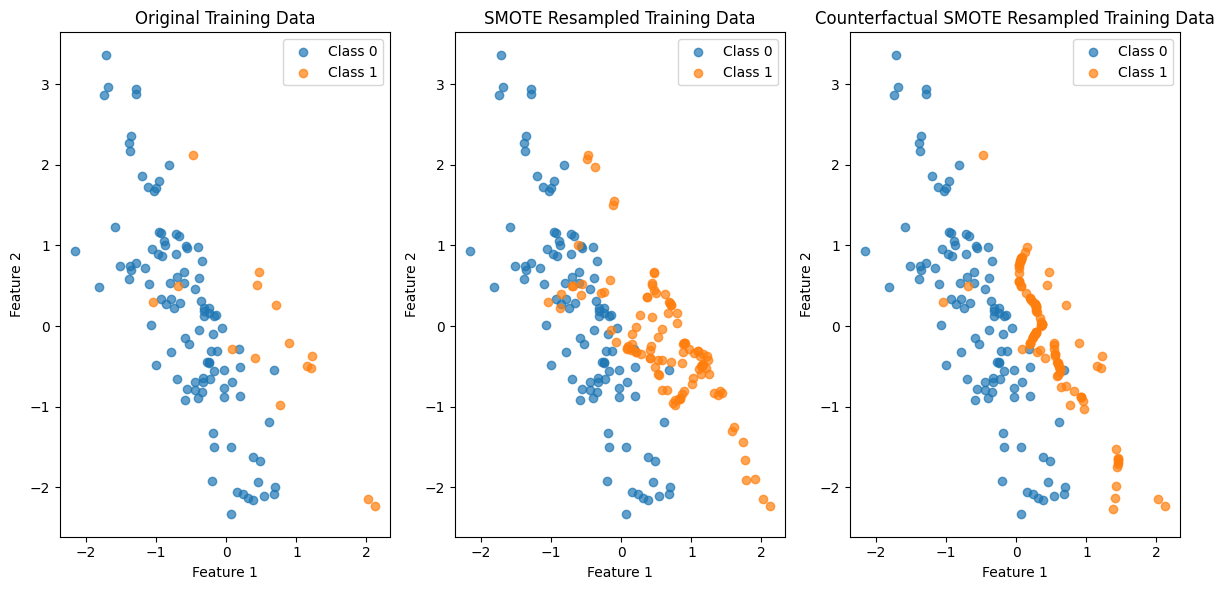

In [10]:
np.random.seed(22)
X, y = make_classification(
    n_samples=150,  
    n_features=2,   
    n_informative=2, 
    n_redundant=0,   
    n_clusters_per_class=2,  
    weights=[0.85, 0.15],     
    class_sep=0.5,   
    random_state=22   
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

smote = SMOTE(random_state=22)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

smote = CounterfactualSMOTE(random_state=22)
X_synthetic, y_synthetic = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', alpha=0.7)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', alpha=0.7)
plt.title('Original Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], label='Class 0', alpha=0.7)
plt.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1], label='Class 1', alpha=0.7)
plt.title('SMOTE Resampled Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_synthetic[y_synthetic == 0][:, 0], X_synthetic[y_synthetic == 0][:, 1], label='Class 0', alpha=0.7)
plt.scatter(X_synthetic[y_synthetic == 1][:, 0], X_synthetic[y_synthetic == 1][:, 1], label='Class 1', alpha=0.7)
plt.title('Counterfactual SMOTE Resampled Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()